In [1]:
import numpy as np 
#from pyuoi.linear_model import UoILasso
import os, sys
sys.path.append('..')
from utils import gen_covariance, gen_beta2, gen_data, selection_accuracy, FNR, FPR

In [2]:
import pdb
import time
import matplotlib.pyplot as plt

In [4]:
from pyuoi.linear_model import UoI_Lasso

In [3]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
n_samples = 500
n_features = 100

sigma = gen_covariance(n_features, 0.25, 10, 1, 0)
beta = gen_beta2(n_features, 10, sparsity = 0.2)
X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, beta = beta)

In [6]:
def empirical_model_loss(y, y_pred, M, penalty):
    n_samples = y.size
    rss = (y.ravel() - y_pred.ravel())**2
    if penalty == 'AICc':
        model_size_penalty = 2 * M + (2 * M**2 + 2 * M)/(n_samples - M - 1)
    else:
        model_size_penalty = penalty * M
    
    llhood = n_samples/2 * (1 + np.log(np.mean(rss)))
    return 2 * llhood + model_size_penalty, 2 * llhood, model_size_penalty

In [7]:
# Does varying the number of esitmation bootstraps affect this failure mode?

In [8]:
n_boots_est = [48, 24, 12, 6, 1]
sparsity = [0.2, 0.4, 0.6, 0.8]

In [25]:
selection_accuracies = np.zeros((len(n_boots_est), len(sparsity)))
false_neg_rates = np.zeros((len(n_boots_est), len(sparsity)))
for i, s in enumerate(sparsity):
    print('Sparsity: %f\n' % s)
    for j, ne in enumerate(n_boots_est):
        beta = gen_beta2(n_features, 10, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, beta = beta) 
        uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100, n_boots_est = ne, 
                         estimation_score = 'AIC')
        uoil.fit(X, y)
        selection_accuracies[j, i] = selection_accuracy(beta.T, uoil.coef_.ravel())
        false_neg_rates[j, i] = FNR(beta.T, uoil.coef_.ravel())

Sparsity: 0.200000

Sparsity: 0.400000

Sparsity: 0.600000

Sparsity: 0.800000



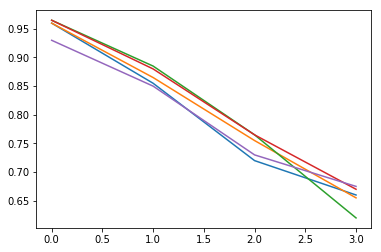

In [26]:
plt.plot(selection_accuracies.T)

In [22]:
selection_accuracies2 = np.zeros((len(n_boots_est), len(sparsity)))
false_neg_rates2 = np.zeros((len(n_boots_est), len(sparsity)))
for i, s in enumerate(sparsity):
    print('Sparsity: %f\n' % s)
    for j, ne in enumerate(n_boots_est):
        beta = gen_beta2(n_features, 10, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, beta = beta) 
        uoil = UoI_Lasso(n_boots_sel = 48, stability_selection = 0.5, n_lambdas = 48, n_boots_est = ne, 
                         estimation_score = 'BIC')
        uoil.fit(X, y)
        selection_accuracies2[j, i] = selection_accuracy(beta.T, uoil.coef_.ravel())
        false_neg_rates2[j, i] = FNR(beta.T, uoil.coef_.ravel())

Sparsity: 0.200000

Sparsity: 0.400000

Sparsity: 0.600000

Sparsity: 0.800000



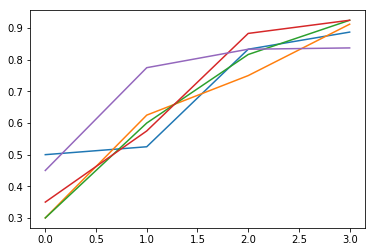

In [23]:
plt.plot(false_neg_rates.T)

In [8]:
np.linspace(0.05, 1, 10)

array([0.05      , 0.15555556, 0.26111111, 0.36666667, 0.47222222,
       0.57777778, 0.68333333, 0.78888889, 0.89444444, 1.        ])

In [9]:
# Not related to number of estimation bootstraps: Why don't we see really high FNR in other analysis? 
# Use our cannonical data generation process - maybe AIC is being boosted by this artificial scenario
# Use the empirical loss to constrast the effect of using the MLE estimate of sigma^2

penalties = [0, 2, np.log(200), 2 * np.log(50)]

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100, 
                 estimation_score = 'AIC', n_boots_est = 48)

# record our selection loss, MSE, and selection accuracy
full_est_scores = []
full_model_scores4 = []
full_model_score_contributions2 = []
full_MSE4 = []
full_selection_accuracy4 = []
full_FNR4 = []
full_FPR4 = []
full_reps_maxidx = []

# Iterate over sparsities
for s in np.linspace(0.05, 1, 10):
    t0 = time.time()
    across_reps_est_scores = []
    across_reps_model_scores = []
    across_reps_model_score_contributions = []
    across_reps_sa = []
    across_reps_fnr = []
    across_reps_fpr = []
    across_reps_MSE = []
    across_reps_maxidx = []
    sigma = gen_covariance(200, 0, 200, 1, 0)
    for rep in range(1):
        sigma = gen_covariance(n_features, 0, n_features, 1, 0)
        beta = gen_beta2(n_features, n_features, sparsity = s)
        X, _, y, _, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, beta = beta)        
        uoil.fit(X, y)
        
        
        coefs = np.zeros(uoil.supports_.shape)
        model_scores = np.zeros((uoil.supports_.shape[0], len(penalties)))
        
        # Fit OLS models:
        MSE = np.zeros(uoil.supports_.shape[0])
        sa = selection_accuracy(beta.T, 1 * uoil.supports_)
        fnr = FNR(beta.T, 1 * uoil.supports_)
        fpr = FPR(beta.T, 1 * uoil.supports_)
        # Do train/test split
        train_idx, test_idx = train_test_split(np.arange(X.shape[0]), train_size = 0.9)
        X_train = X[train_idx, :]
        X_test = X[test_idx, :]
        y_train = y[train_idx]
        y_test = y[test_idx]
        # Fit OLS models
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X_train[:, uoil.supports_[i, :]], y_train).coef_.ravel()
            for j in range(len(penalties)):
                l1, l2, l3 = empirical_model_loss(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]), 
                                                np.count_nonzero(1 * uoil.supports_[i, :]),
                                                penalties[j])
                model_scores[i, j] = l1
        across_reps_est_scores.append(uoil.scores_[0, :])
        across_reps_sa.append(sa)
        across_reps_fnr.append(fnr)
        across_reps_fpr.append(fpr)
        across_reps_MSE.append(MSE)
        across_reps_maxidx.append(uoil.rp_max_idx_[0])
        across_reps_model_scores.append(model_scores)
        
    # Append the model_scores to the master list
    full_est_scores.append(across_reps_est_scores)
    full_model_scores4.append(across_reps_model_scores)
    full_model_score_contributions2.append(across_reps_model_score_contributions)
    full_MSE4.append(across_reps_MSE)
    full_selection_accuracy4.append(across_reps_sa)
    full_FNR4.append(across_reps_fnr)
    full_FPR4.append(across_reps_fpr)
    full_reps_maxidx.append(across_reps_maxidx)
    print(time.time() - t0)

C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


7.431111097335815


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.063704013824463


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.391982793807983


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.963754177093506


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.334251642227173


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.593876600265503


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.954529285430908


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


8.356135845184326


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


9.22587513923645
10.369651079177856


C:\Users\Ankit\Miniconda3\envs\nse\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
selected_sa = np.zeros(10)      
selected_FNR = np.zeros(10)

manual_sa = np.zeros(10)
manual_FNR = np.zeros(10)

est_scores = np.zeros(10)
manual_scores = np.zeros(10)

for i, s in enumerate(np.linspace(0.05, 1, 10)):

    selected_sa[i] = full_selection_accuracy4[i][0][full_reps_maxidx[i][0]]
    selected_FNR[i] = full_FNR4[i][0][full_reps_maxidx[i][0]]
    est_scores[i] = full_est_scores[i][0][full_reps_maxidx[i][0]]

    selected_index = np.argmin(full_model_scores4[i][0][:, 1])
    manual_sa[i] = full_selection_accuracy4[i][0][selected_index]
    manual_FNR[i] = full_FNR4[i][0][selected_index]
    manual_scores[i] = full_model_scores4[i][0][selected_index, 1]

In [20]:
full_est_scores[5][0]

array([-461.11770508, -459.3187422 , -458.50960167, -465.74775   ,
       -469.52516658, -475.03952779, -478.14390309, -477.08205776,
       -475.97686437, -466.1619337 , -470.87790243, -465.25464674,
       -466.05180402, -467.62930057, -468.79788617, -477.16203121,
       -478.79392473, -479.13000849, -482.98267583, -489.39277331,
       -489.92295887, -493.56493711, -494.69714021, -499.35615194,
       -503.1518944 , -510.32113507, -516.61588264, -526.25226256,
       -527.65294611, -533.91658936, -535.27435552, -536.98761616,
       -543.10823156, -546.94003116, -552.04517617, -555.81068783,
       -560.04741431, -561.7034066 , -563.65978437, -569.17322601,
       -571.3670121 , -580.14851166, -586.37633642, -590.58039658,
       -596.53088748, -598.70313283, -601.597726  , -603.62981189])

In [21]:
full_model_scores4[5][0][:, 1]

array([446.1778642 , 451.05211022, 447.70044202, 446.06008346,
       443.36791784, 452.41322591, 455.57631409, 453.84424335,
       459.43540868, 460.36416921, 461.73019289, 457.63126022,
       462.25200749, 465.64924173, 467.37028285, 473.11469348,
       474.90611194, 477.413366  , 480.55431015, 484.48733773,
       488.97642836, 492.94030145, 494.05787813, 499.1443715 ,
       502.71963123, 509.26057845, 513.8835313 , 523.76088122,
       527.09043483, 532.46253867, 533.73438835, 535.30133118,
       540.56461748, 544.55558849, 548.62816401, 552.9450143 ,
       557.42189365, 559.40622984, 561.31863317, 567.16808628,
       569.05963786, 577.94956701, 584.7072031 , 588.81682028,
       596.33197896, 598.35904958, 600.89964564, 602.9093996 ])

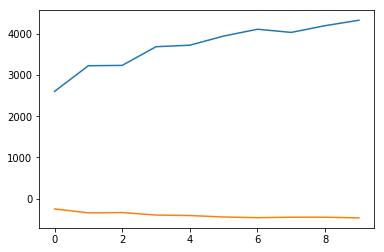

In [14]:
plt.plot(manual_scores)
plt.plot(est_scores)

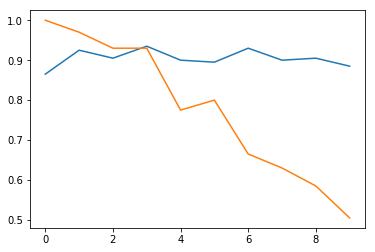

In [11]:
plt.plot(selected_sa)
plt.plot(manual_sa)

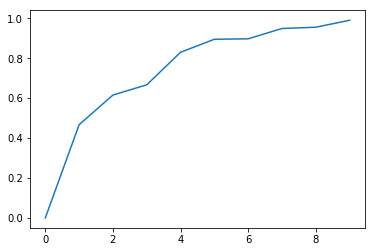

In [49]:
plt.plot(selected_FNR)